# Allstate Claims Data

In [24]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from sklearn.model_selection import KFold,GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
%matplotlib inline

## Load Data

In [140]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_size = train_data.shape[0]
test_size = test_data.shape[0]
print('train_size is: %d, test_size is: %d' %(train_size, test_size))

train_size is: 188318, test_size is: 125546


## Merge train and test
Apply same transformations on both train data and test data at the same time to save time.

In [141]:
full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
full_data.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(313864, 132)

In [142]:
train_data.shape, test_data.shape

((188318, 132), (125546, 131))

In [143]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313864 entries, 0 to 313863
Columns: 132 entries, cat1 to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 316.1+ MB


## Group Features
Classify features into categorical ones and numerical ones, so that we can preprocess them seperately.

In [144]:
full_data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313864 entries, 0 to 313863
Data columns (total 132 columns):
cat1      313864 non-null object
cat10     313864 non-null object
cat100    313864 non-null object
cat101    313864 non-null object
cat102    313864 non-null object
cat103    313864 non-null object
cat104    313864 non-null object
cat105    313864 non-null object
cat106    313864 non-null object
cat107    313864 non-null object
cat108    313864 non-null object
cat109    313864 non-null object
cat11     313864 non-null object
cat110    313864 non-null object
cat111    313864 non-null object
cat112    313864 non-null object
cat113    313864 non-null object
cat114    313864 non-null object
cat115    313864 non-null object
cat116    313864 non-null object
cat12     313864 non-null object
cat13     313864 non-null object
cat14     313864 non-null object
cat15     313864 non-null object
cat16     313864 non-null object
cat17     313864 non-null object
cat18     313864 non-null obje

In [145]:
set(full_data.dtypes.values)

{dtype('int64'), dtype('float64'), dtype('O')}

In [146]:
data_types = full_data.dtypes
cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='float64'].index)+list(data_types[data_types=='int64'].index)
id_cols = 'id'
target_cols = 'loss'
con_cols.remove('id')
con_cols.remove('loss')
print('Categorical features:', len(cat_cols), '\n', cat_cols)
print('Continuous features:', len(con_cols), '\n', con_cols)

Categorical features: 116 
 ['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat11', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat2', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat3', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat4', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat5', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat6', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat7', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat8', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat9', 'cat90', 

## EDA
Do exploratory Data Analysis

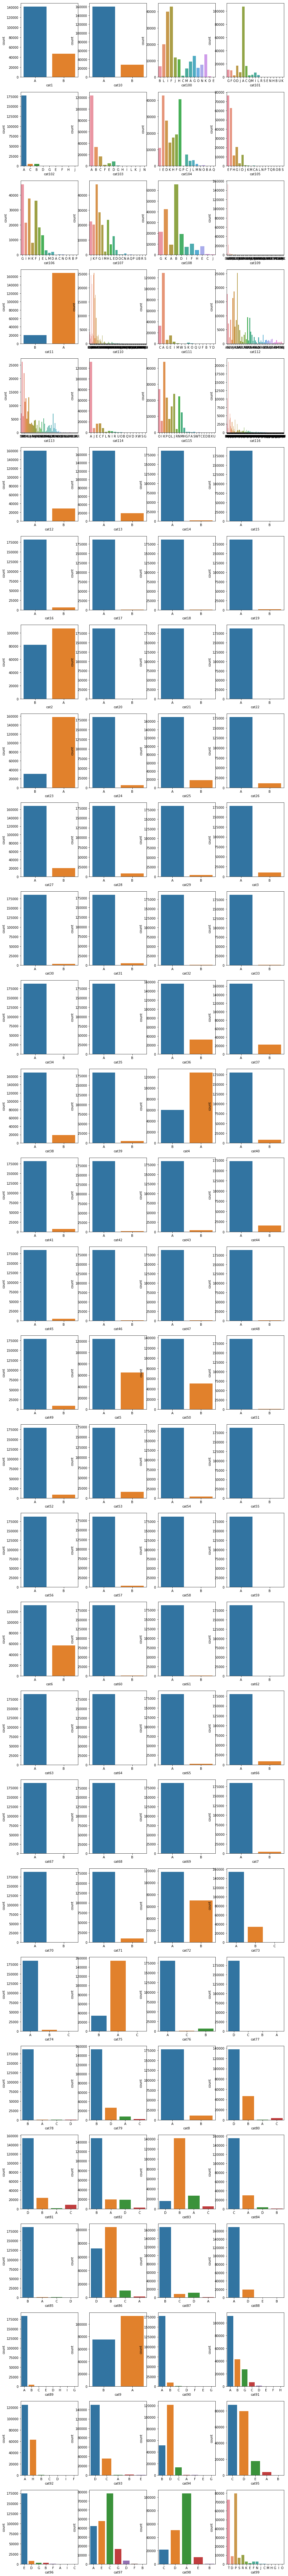

In [9]:
n_cols = 4
n_rows = 29

fig = plt.figure(figsize=(15,150))
for i, feat_name in enumerate(cat_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.countplot(x=cat_cols[i], data=train_data)

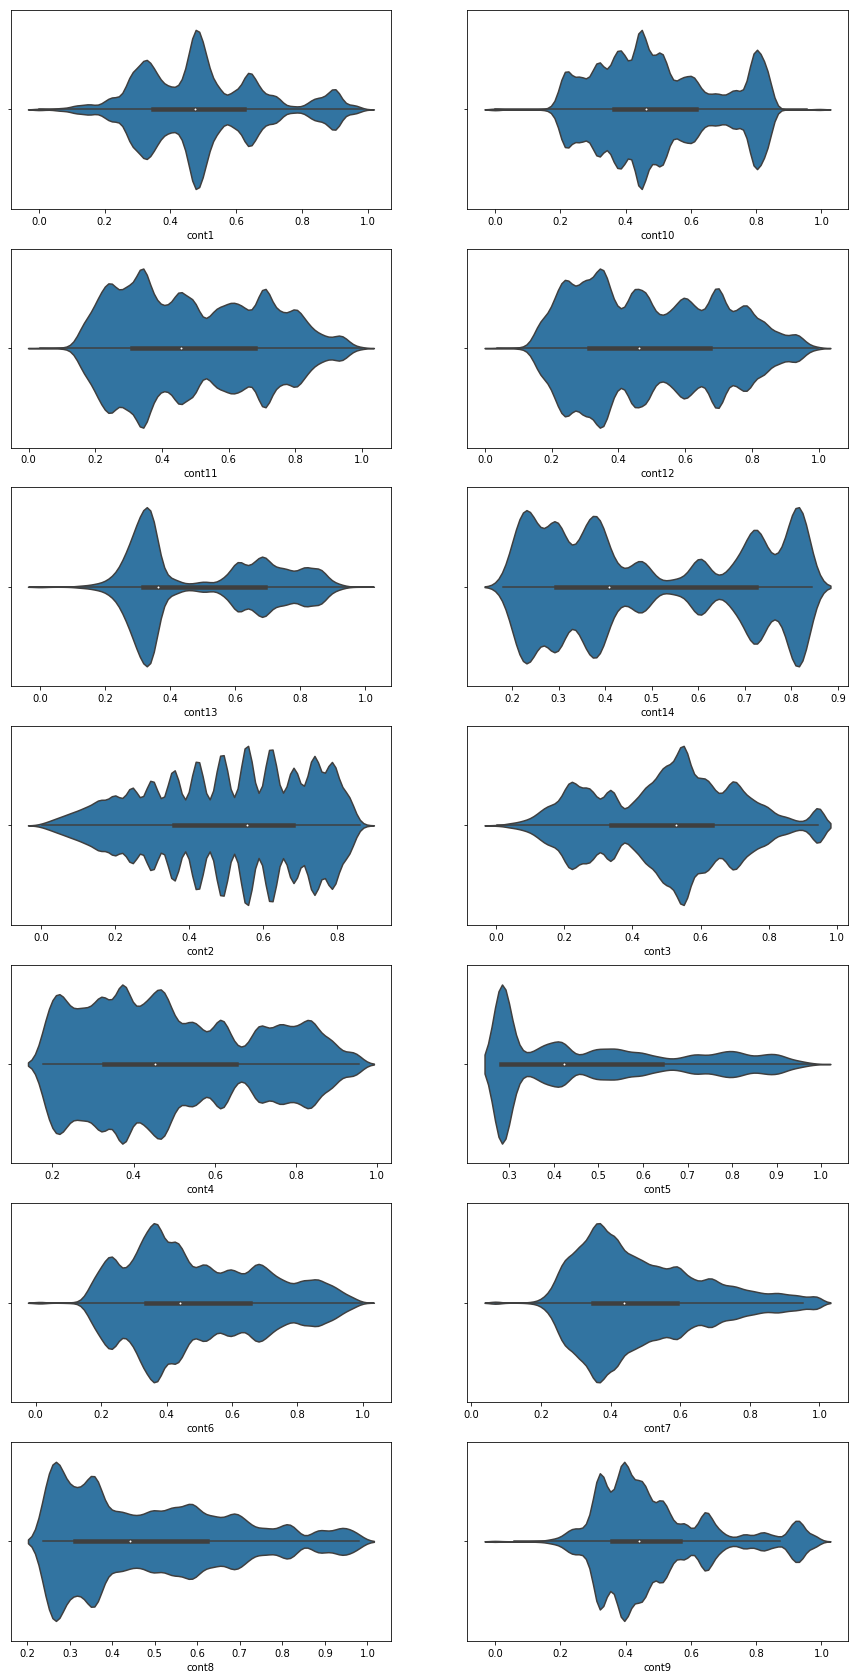

In [10]:
n_cols = 2
n_rows = 7

fig = plt.figure(figsize=(15,30))
for i, feat_name in enumerate(con_cols[:14]):
    plt.subplot(n_rows, n_cols, i+1)
    sns.violinplot(x=con_cols[i], data=train_data)

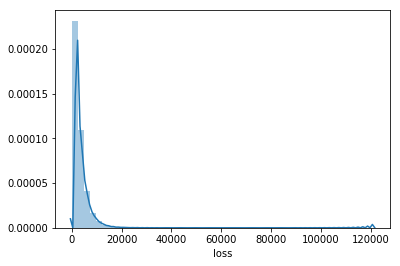

In [11]:
sns.distplot(train_data.loss)

In [12]:
train_data.loss.quantile(0.995)

16616.923050000045

In [93]:
a=pd.Series([1,1,1,3,3,3,3,6,7,8])
len(a)

10

In [94]:
a.quantile(0.9)
# Position=1+(10-1)*0.9=9.1,so the position is between the ninth and tenth, fraction=0.1
# 7+(8-7)*0.1=7.1

7.1

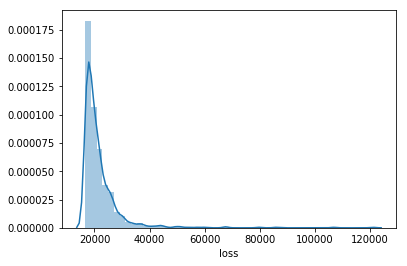

In [13]:
sns.distplot(train_data.query('loss>loss.quantile(0.995)').loss)

In [108]:
#the range of loss
train_data.loss.max(), train_data.loss.min(), train_data.loss.median()

(121012.25, 0.67, 2115.5699999999997)

In [105]:
np.log1p(1e-99), np.log(1+1e-99)
#when value is tiny, np.log1p is more accurate

(1e-99, 0.0)

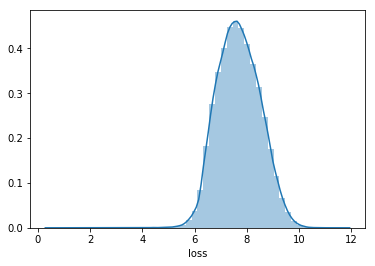

In [96]:
# for this case, there is no difference between log1p, log. as the data is>1
loss = np.log1p(train_data.loss)
sns.distplot(loss)

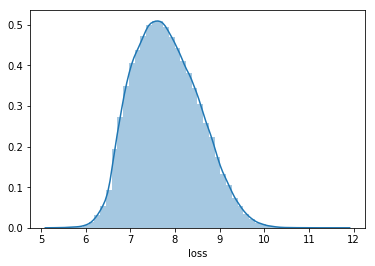

In [97]:
loss = np.log(train_data.loss+200)
sns.distplot(loss)

In [16]:
#convert loss to [5,12]
loss.max(), loss.min()

(11.70529842011712, 5.301661767798426)

In [17]:
train_data['cont10'].max()

0.99498

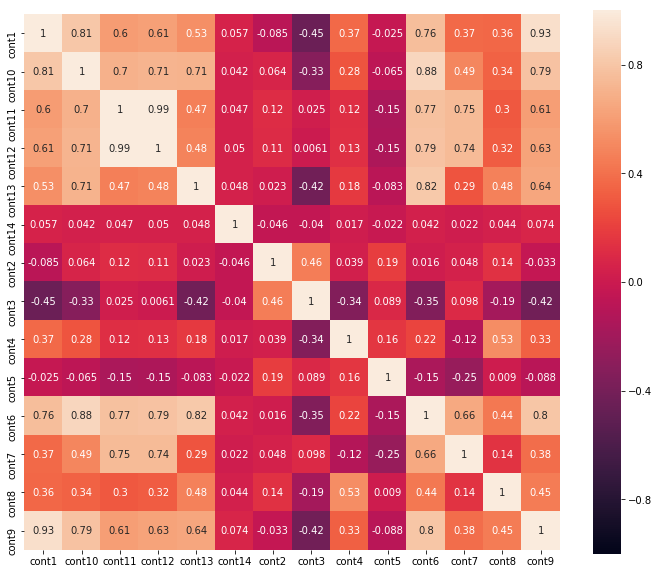

In [20]:
corrmat = train_data[con_cols].corr()
fig = plt.figure(figsize=(12,10))
sns.heatmap(corrmat,  vmax=1,vmin=-1,annot=True,square=True)

### Exploring high cardinality categorical feature

In [147]:
high_cardinality = ['cat109', 'cat110', 'cat112', 'cat113', 'cat116']

#### cat109-frequency encoding 

In [148]:
print(len(train_data['cat109'].value_counts()))
print(train_data['cat109'].value_counts()[:15])

84
BI    152918
AB     21933
BU      3142
K       2999
G       1353
BQ      1067
N        461
M        446
BO       329
BH       257
D        214
AR       208
AT       200
CL       178
AS       159
Name: cat109, dtype: int64


In [149]:
cat109_freq = full_data.groupby('cat109').size().reset_index()
cat109_freq

,cat109,0
0,A,90
1,AA,28
2,AB,36289
3,AD,2
4,AE,81
5,AF,13
6,AG,1
7,AH,95
8,AI,30
9,AJ,91


In [150]:
cat109_freq.columns = ['cat109', 'cat109_freq']
cat109_freq[:3]

,cat109,cat109_freq
0,A,90
1,AA,28
2,AB,36289


In [151]:
full_data = pd.merge(full_data, cat109_freq, how='left', on='cat109')

In [152]:
cat_cols.remove('cat109')
con_cols.append('cat109_freq')

In [153]:
len(cat_cols), len(con_cols)

(115, 15)

#### cat110-frequency encoding  

In [154]:
print(len(full_data['cat110'].value_counts()))
print(full_data['cat110'].value_counts())

134
CL    42097
CS    40996
EG    40885
EB    35965
CO    29216
BT    27267
EL    15203
BC     6857
DW     6005
CQ     5437
DX     5210
AI     4941
BP     4746
C      4577
W      4567
AC     4306
CM     3238
BS     3211
DK     2968
V      2841
A      2200
EE     2012
EF     1929
CI     1795
DM     1358
CR     1268
AM     1023
AD     1009
AP      920
T       870
      ...  
BV       10
DN        9
DT        9
AG        9
CX        9
AH        9
H         8
BU        6
DB        6
EK        5
DD        5
CU        5
EJ        5
BM        4
Q         4
AN        3
AF        3
AS        2
S         2
BN        2
EI        2
CA        1
BD        1
EH        1
BI        1
BH        1
DV        1
BK        1
EN        1
CB        1
Name: cat110, Length: 134, dtype: int64


In [155]:
cat110_freq = full_data.groupby('cat110').size().reset_index()
cat110_freq[:3]

,cat110,0
0,A,2200
1,AA,32
2,AB,90


In [156]:
cat110_freq.columns = ['cat110', 'cat110_freq']
cat110_freq[:3]

,cat110,cat110_freq
0,A,2200
1,AA,32
2,AB,90


In [157]:
full_data = pd.merge(full_data, cat110_freq, how='left', on='cat110')

In [158]:
cat_cols.remove('cat110')
con_cols.append('cat110_freq')
len(cat_cols), len(con_cols)

(114, 16)

#### cat112-frequency encoding   

In [159]:
print(len(full_data['cat112'].value_counts()))
print(full_data['cat112'].value_counts())

51
E     42109
AH    31149
AS    29310
J     27074
AF    15498
AN    15320
N     13924
U     13901
AV    11968
AK    11069
K     10124
AI     7977
S      7107
AP     6618
G      5268
F      5226
AW     5177
A      4059
AR     3921
C      3745
O      3633
D      2690
AD     2596
AY     2392
Y      2316
AG     2202
AT     2151
AA     2112
AM     1951
R      1909
AL     1860
AX     1729
X      1582
I      1565
AE     1377
Q      1268
V      1121
H       906
T       893
AO      880
L       809
W       794
B       729
M       715
AU      714
AC      697
P       679
AB      426
BA      337
AJ      236
AQ       51
Name: cat112, dtype: int64


In [160]:
cat112_freq = full_data.groupby('cat112').size().reset_index()
cat112_freq[:3]

,cat112,0
0,A,4059
1,AA,2112
2,AB,426


In [161]:
cat112_freq.columns = ['cat112', 'cat112_freq']
cat112_freq[:3]

,cat112,cat112_freq
0,A,4059
1,AA,2112
2,AB,426


In [162]:
full_data = pd.merge(full_data, cat112_freq, how='left', on='cat112')

In [163]:
cat_cols.remove('cat112')
con_cols.append('cat112_freq')
len(cat_cols), len(con_cols)

(113, 17)

#### cat113-frequency encoding   

In [164]:
print(len(full_data['cat113'].value_counts()))
print(full_data['cat113'].value_counts())

63
BM    43756
AE    36915
L     21838
AX    21054
Y     19146
K     12785
X     11670
S     11645
AF    10043
AN     8701
H      8439
AT     7735
AJ     7414
AD     7320
AS     6490
AK     5830
BN     5807
I      5445
A      5412
J      5238
N      4747
Q      4618
BC     4603
BJ     4332
M      4182
AG     4024
AW     3044
BG     2930
AU     2746
AO     2710
      ...  
BK     1168
AV      875
AY      768
AM      755
AI      742
BF      585
BD      562
AH      319
C       237
BB       86
BA       67
BI       55
G        34
AB       30
AQ       27
V        23
U        14
O        14
AP       10
E         9
BL        6
AL        4
BE        3
B         3
P         2
T         2
AR        2
AA        1
R         1
AC        1
Name: cat113, Length: 63, dtype: int64


In [165]:
cat113_freq = full_data.groupby('cat113').size().reset_index()
cat113_freq[:3]

,cat113,0
0,A,5412
1,AA,1
2,AB,30


In [166]:
cat113_freq.columns = ['cat113', 'cat113_freq']
cat113_freq[:3]

,cat113,cat113_freq
0,A,5412
1,AA,1
2,AB,30


In [167]:
full_data = pd.merge(full_data, cat113_freq, how='left', on='cat113')

In [168]:
cat_cols.remove('cat113')
con_cols.append('cat113_freq')
len(cat_cols), len(con_cols)

(112, 18)

#### cat116-frequency encoding 

In [169]:
print(len(full_data['cat116'].value_counts()))
print(full_data['cat116'].value_counts())

349
HK    35076
DJ    33974
CK    16847
DP    15387
GS    14649
CR    11411
HX     9301
DC     7543
HG     7361
IE     7111
HQ     6692
HV     6396
GC     6355
LM     5524
LB     5398
LN     5291
KW     5173
HJ     4518
GK     4372
DF     4192
IG     3760
LO     3519
MD     3290
CB     3236
HB     3234
LF     3103
GI     2975
BY     2677
KC     2538
GE     2300
      ...  
BR        1
ET        1
AT        1
DY        1
JT        1
EM        1
AM        1
IK        1
HU        1
MF        1
EX        1
AQ        1
ER        1
FN        1
FO        1
BI        1
A         1
BJ        1
IB        1
BH        1
IO        1
DQ        1
MT        1
C         1
JI        1
N         1
IX        1
BN        1
MB        1
AI        1
Name: cat116, Length: 349, dtype: int64


In [170]:
cat116_freq = full_data.groupby('cat116').size().reset_index()
cat116_freq[:3]

,cat116,0
0,A,1
1,AA,9
2,AB,2


In [171]:
cat116_freq.columns = ['cat116', 'cat116_freq']
cat116_freq[:3]

,cat116,cat116_freq
0,A,1
1,AA,9
2,AB,2


In [172]:
full_data = pd.merge(full_data, cat116_freq, how='left', on='cat116')

In [173]:
cat_cols.remove('cat116')
con_cols.append('cat116_freq')
len(cat_cols), len(con_cols)

(111, 19)

## Feature Engineering--categorical features 

### Label Encoding 

In [174]:
LBE = preprocessing.LabelEncoder()
start = time.time()
LE_map = {}
for cat_col in cat_cols:
    full_data[cat_col] = LBE.fit_transform(full_data[cat_col])
    LE_map[cat_col] = dict(zip(LBE.classes_, LBE.transform(LBE.classes_)))
print('Label Encoding finished in %.3f seconds'% (time.time()-start))

Label Encoding finished in 45.319 seconds


In [175]:
LE_map 

{'cat1': {'A': 0, 'B': 1},
 'cat10': {'A': 0, 'B': 1},
 'cat100': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14},
 'cat101': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14,
  'Q': 15,
  'R': 16,
  'S': 17,
  'U': 18},
 'cat102': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'J': 8},
 'cat103': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13},
 'cat104': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L': 11,
  'M': 12,
  'N': 13,
  'O': 14,
  'P': 15,
  'Q': 16},
 'cat105': {'A': 0,
  'B': 1,
  'C': 2,
  'D': 3,
  'E': 4,
  'F': 5,
  'G': 6,
  'H': 7,
  'I': 8,
  'J': 9,
  'K': 10,
  'L

### One Hot Encoding 

In [176]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start = time.time()
full_data_sparse = OHE.fit_transform(full_data[cat_cols])
print('One hot encoding finished in %.3f second'%(time.time()-start))
print(full_data_sparse.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


One hot encoding finished in 4.252 second
(313864, 494)


In [177]:
#OneHotEncoder & pandas.get_dummies
#OneHotEncoder(sklearn)cannot process string values directly. If your nominal features are strings, 
#then you need to first map them into integers.
#pandas.get_dummies is kind of the opposite. By default, it only converts string columns into 
#one-hot representation, unless columns are specified.

## Continuous Features 

In [202]:
from scipy.stats import skew, boxcox
# apply boxcox to convert skewed features into normal distribution features

In [179]:
skewed_cols = full_data[con_cols].apply(lambda x:skew(x.dropna()))
skewed_cols.sort_values()

cat109_freq   -1.626094
cat110_freq   -0.637908
cont2         -0.311146
cont3         -0.007023
cont14         0.250673
cont11         0.281139
cont12         0.291997
cont10         0.352116
cat112_freq    0.371395
cont13         0.376138
cont4          0.417559
cont6          0.458413
cont1          0.513205
cont8          0.673237
cont5          0.679610
cat113_freq    0.680247
cont7          0.825889
cat116_freq    0.910617
cont9          1.067247
dtype: float64

In [180]:
skewed_cols = skewed_cols[abs(skewed_cols)>0.25].index.values
skewed_cols

array(['cont1', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cont2',
       'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9',
       'cat109_freq', 'cat110_freq', 'cat112_freq', 'cat113_freq',
       'cat116_freq'], dtype=object)

In [181]:
for skewed_col in skewed_cols:
    full_data[skewed_col],lam = boxcox(full_data[skewed_col]+1)
#boxcox only accept positive value

In [182]:
# z = (x - u) / s
STS = preprocessing.StandardScaler()
for con_col in con_cols:
    full_data[con_col] = STS.fit_transform(full_data[con_col].values.reshape(-1,1))

In [183]:
#OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                #for var in feature_OHE for level in LE_map[var]]

In [184]:
full_data_sparse.toarray()

array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [185]:
OHE_vars = [var + '_' + str(level) for var in LE_map for level in LE_map[var]]
OHE_vars

['cat1_A',
 'cat1_B',
 'cat10_A',
 'cat10_B',
 'cat100_A',
 'cat100_B',
 'cat100_C',
 'cat100_D',
 'cat100_E',
 'cat100_F',
 'cat100_G',
 'cat100_H',
 'cat100_I',
 'cat100_J',
 'cat100_K',
 'cat100_L',
 'cat100_M',
 'cat100_N',
 'cat100_O',
 'cat101_A',
 'cat101_B',
 'cat101_C',
 'cat101_D',
 'cat101_E',
 'cat101_F',
 'cat101_G',
 'cat101_H',
 'cat101_I',
 'cat101_J',
 'cat101_K',
 'cat101_L',
 'cat101_M',
 'cat101_N',
 'cat101_O',
 'cat101_Q',
 'cat101_R',
 'cat101_S',
 'cat101_U',
 'cat102_A',
 'cat102_B',
 'cat102_C',
 'cat102_D',
 'cat102_E',
 'cat102_F',
 'cat102_G',
 'cat102_H',
 'cat102_J',
 'cat103_A',
 'cat103_B',
 'cat103_C',
 'cat103_D',
 'cat103_E',
 'cat103_F',
 'cat103_G',
 'cat103_H',
 'cat103_I',
 'cat103_J',
 'cat103_K',
 'cat103_L',
 'cat103_M',
 'cat103_N',
 'cat104_A',
 'cat104_B',
 'cat104_C',
 'cat104_D',
 'cat104_E',
 'cat104_F',
 'cat104_G',
 'cat104_H',
 'cat104_I',
 'cat104_J',
 'cat104_K',
 'cat104_L',
 'cat104_M',
 'cat104_N',
 'cat104_O',
 'cat104_P',
 'cat

In [186]:
#full_data = pd.concat((full_data, pd.DataFrame(OHE_data,columns=OHE_vars)), axis = 1)
OHE_data = pd.DataFrame(full_data_sparse.toarray(), columns=OHE_vars)
OHE_data.columns.values

array(['cat1_A', 'cat1_B', 'cat10_A', 'cat10_B', 'cat100_A', 'cat100_B',
       'cat100_C', 'cat100_D', 'cat100_E', 'cat100_F', 'cat100_G',
       'cat100_H', 'cat100_I', 'cat100_J', 'cat100_K', 'cat100_L',
       'cat100_M', 'cat100_N', 'cat100_O', 'cat101_A', 'cat101_B',
       'cat101_C', 'cat101_D', 'cat101_E', 'cat101_F', 'cat101_G',
       'cat101_H', 'cat101_I', 'cat101_J', 'cat101_K', 'cat101_L',
       'cat101_M', 'cat101_N', 'cat101_O', 'cat101_Q', 'cat101_R',
       'cat101_S', 'cat101_U', 'cat102_A', 'cat102_B', 'cat102_C',
       'cat102_D', 'cat102_E', 'cat102_F', 'cat102_G', 'cat102_H',
       'cat102_J', 'cat103_A', 'cat103_B', 'cat103_C', 'cat103_D',
       'cat103_E', 'cat103_F', 'cat103_G', 'cat103_H', 'cat103_I',
       'cat103_J', 'cat103_K', 'cat103_L', 'cat103_M', 'cat103_N',
       'cat104_A', 'cat104_B', 'cat104_C', 'cat104_D', 'cat104_E',
       'cat104_F', 'cat104_G', 'cat104_H', 'cat104_I', 'cat104_J',
       'cat104_K', 'cat104_L', 'cat104_M', 'cat104_N', '

In [188]:
full_data_1 = pd.concat([full_data.id, full_data[con_cols], OHE_data, full_data.loss], axis=1)
full_data_1.shape

(313864, 515)

In [189]:
full_data_1.to_csv('full_data_freq.csv', index=False)

## XGBoost 

In [2]:
full_data = pd.read_csv('full_data_freq.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_size = train_data.shape[0]
test_size = test_data.shape[0]

In [3]:
cols = list(full_data.columns.values)
cols.remove('id')
cols.remove('loss')
cols

['cont1',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cat109_freq',
 'cat110_freq',
 'cat112_freq',
 'cat113_freq',
 'cat116_freq',
 'cat1_A',
 'cat1_B',
 'cat10_A',
 'cat10_B',
 'cat100_A',
 'cat100_B',
 'cat100_C',
 'cat100_D',
 'cat100_E',
 'cat100_F',
 'cat100_G',
 'cat100_H',
 'cat100_I',
 'cat100_J',
 'cat100_K',
 'cat100_L',
 'cat100_M',
 'cat100_N',
 'cat100_O',
 'cat101_A',
 'cat101_B',
 'cat101_C',
 'cat101_D',
 'cat101_E',
 'cat101_F',
 'cat101_G',
 'cat101_H',
 'cat101_I',
 'cat101_J',
 'cat101_K',
 'cat101_L',
 'cat101_M',
 'cat101_N',
 'cat101_O',
 'cat101_Q',
 'cat101_R',
 'cat101_S',
 'cat101_U',
 'cat102_A',
 'cat102_B',
 'cat102_C',
 'cat102_D',
 'cat102_E',
 'cat102_F',
 'cat102_G',
 'cat102_H',
 'cat102_J',
 'cat103_A',
 'cat103_B',
 'cat103_C',
 'cat103_D',
 'cat103_E',
 'cat103_F',
 'cat103_G',
 'cat103_H',
 'cat103_I',
 'cat103_J',
 'cat103_K',
 'cat103_L',
 'cat103_M',
 

In [4]:
feat = cols

In [5]:
train_x = full_data[:train_size][feat]
test_x = full_data[train_size:][feat]
train_y = np.log(full_data[:train_size].loss.values+200)
ID = full_data[train_size:].id.values

In [6]:
from scipy.stats import skew, boxcox
skew(full_data[:train_size].loss.values)

3.7949281496777445

In [7]:
skew(np.log(full_data[:train_size].loss.values+200))

0.3014089397765396

In [8]:
full_data[:train_size].loss.max(), full_data[:train_size].loss.min()

(121012.25, 0.67)

In [9]:
train_y.max(), train_y.min()

(11.70529842011712, 5.301661767798426)

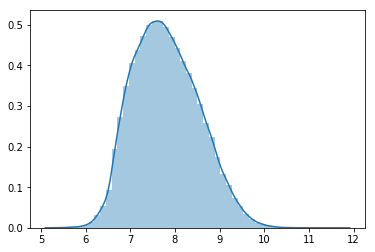

In [10]:
sns.distplot(train_y)

In [11]:
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return metrics.mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [14]:
cv_params = {'learning_rate':[0.02, 0.04, 0.06, 0.08]}
other_params = {'n_estimators':1500, 'max_depth':6, 'min_child_weight':50,'gamma':0.8,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=10, n_jobs=1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... learning_rate=0.02, score=-1139.2593881099056, total=77.1min
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 77.4min remaining:    0.0s


[CV] .... learning_rate=0.02, score=-1143.3829690715625, total=79.6min
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 157.7min remaining:    0.0s


[CV] ... learning_rate=0.02, score=-1141.5837188896628, total=334.7min
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 492.7min remaining:    0.0s


[CV] .... learning_rate=0.02, score=-1139.6344286106967, total=76.9min
[CV] learning_rate=0.04 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 569.8min remaining:    0.0s


[CV] .... learning_rate=0.04, score=-1138.8602702029998, total=72.4min
[CV] learning_rate=0.04 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 642.4min remaining:    0.0s


[CV] .... learning_rate=0.04, score=-1143.9133695353569, total=76.9min
[CV] learning_rate=0.04 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 719.7min remaining:    0.0s


[CV] .... learning_rate=0.04, score=-1141.1975236562148, total=76.9min
[CV] learning_rate=0.04 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 796.9min remaining:    0.0s


[CV] .... learning_rate=0.04, score=-1140.1854321536423, total=73.8min
[CV] learning_rate=0.06 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 871.0min remaining:    0.0s


[CV] ..... learning_rate=0.06, score=-1140.413683541375, total=78.4min
[CV] learning_rate=0.06 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 949.7min remaining:    0.0s


[CV] ..... learning_rate=0.06, score=-1145.678709085599, total=72.7min
[CV] learning_rate=0.06 ..............................................
[CV] .... learning_rate=0.06, score=-1141.6937629279046, total=75.6min
[CV] learning_rate=0.06 ..............................................
[CV] .... learning_rate=0.06, score=-1143.1804127141286, total=75.6min
[CV] learning_rate=0.08 ..............................................
[CV] ..... learning_rate=0.08, score=-1145.384366859637, total=75.0min
[CV] learning_rate=0.08 ..............................................
[CV] ..... learning_rate=0.08, score=-1148.762307437401, total=76.9min
[CV] learning_rate=0.08 ..............................................
[CV] ...... learning_rate=0.08, score=-1144.90257847688, total=76.1min
[CV] learning_rate=0.08 ..............................................
[CV] ..... learning_rate=0.08, score=-1147.136028002228, total=75.5min


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 1478.8min finished


Best score: -1140.965
Best parameters set: {'learning_rate': 0.02}


In [20]:
print('done')

done


In [19]:
cv_params = {'n_estimators':[1000, 1250, 1500, 1750]}
other_params = {'learning_rate':0.02, 'max_depth':6, 'min_child_weight':50,'gamma':0.8,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=20, n_jobs=-1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 145.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 146.2min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 146.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 146.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 293.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 294.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 294.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 296.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 427.3min
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed: 428.2min remaining: 256.9min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 428.4min remaining: 194.7min
[Parallel(n_jobs=-1)]: Done  12 out of  16 | elapsed: 430.3min remaining: 143.4min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 623.1min remaining: 143.8min
[Parallel(n_jobs=-1)]: Do

Best score: -1139.825
Best parameters set: {'n_estimators': 1750}


In [21]:
cv_params = {'n_estimators':[1600]}
other_params = {'learning_rate':0.02, 'max_depth':6, 'min_child_weight':50,'gamma':0.8,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=20, n_jobs=-1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 184.7min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 184.8min remaining: 184.8min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 185.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 185.2min finished


Best score: -1140.519
Best parameters set: {'n_estimators': 1600}


In [12]:
cv_params = {'n_estimators':[1700, 1800]}
other_params = {'learning_rate':0.02, 'max_depth':6, 'min_child_weight':50,'gamma':0.8,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=3, n_jobs=-1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 186.9min remaining: 186.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 610.0min finished


Best score: -1139.656
Best parameters set: {'n_estimators': 1800}


In [15]:
optimized_GBM.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([11139.26295823, 25323.03378296]),
 'std_fit_time': array([3.22703189, 5.4978108 ]),
 'mean_score_time': array([17.17690325, 14.54973692]),
 'std_score_time': array([0.68958457, 2.382727  ]),
 'param_n_estimators': masked_array(data=[1700, 1800],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1700}, {'n_estimators': 1800}],
 'split0_test_score': array([-1138.67679607, -1138.36291672]),
 'split1_test_score': array([-1142.27178215, -1141.81982798]),
 'split2_test_score': array([-1140.73713063, -1140.20139821]),
 'split3_test_score': array([-1138.54891195, -1138.24069625]),
 'mean_test_score': array([-1140.05865961, -1139.65621441]),
 'std_test_score': array([1.54492414, 1.4709523 ]),
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_train_score': array([-1084.67120268, -1082.19582178]),
 'split1_train_score': array([-1080.74787618, -1078.02821348]),
 'split2_train_score': array([-1082.4239

In [16]:
cv_params = {'max_depth':[4,6,8,10]}
other_params = {'n_estimators':1800,'learning_rate':0.02, 'min_child_weight':50,'gamma':0.8,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=10, n_jobs=-1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 534.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 780.6min remaining: 354.8min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 1010.8min remaining: 233.3min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 1011.0min finished


Best score: -1134.730
Best parameters set: {'max_depth': 10}


In [18]:
cv_params = {'max_depth':[10]}
other_params = {'n_estimators':1800,'learning_rate':0.01, 'min_child_weight':50,'gamma':0.8,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=10, n_jobs=-1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 406.0min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 406.3min remaining: 406.3min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 406.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 406.3min finished


Best score: -1134.571
Best parameters set: {'max_depth': 10}


In [19]:
cv_params = {'gamma':[0.2,0.4,0.6,0.8]}
other_params = {'n_estimators':1800,'learning_rate':0.01, 'min_child_weight':50,'max_depth':10,'seed':1234,'subsample':0.78,'colsample_bytree':0.67,
                'nthread': -1, 'objective':logregobj}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring=log_mae_scorer, cv=4, verbose=10, n_jobs=-1)
optimized_GBM.fit(train_x, train_y)
print("Best score: %0.3f" % optimized_GBM.best_score_)
print("Best parameters set:", optimized_GBM.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 479.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 709.6min remaining: 322.5min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 946.4min remaining: 218.4min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 948.2min finished


Best score: -1134.115
Best parameters set: {'gamma': 0.2}


In [20]:
xgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.01, # smaller, better results, more time
                       n_estimators = 1800, # Number of boosted trees to fit.
                       max_depth=10, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.2, # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
xgr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.67, gamma=0.2, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=50, missing=None, n_estimators=1800, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1234, silent=False,
       subsample=0.78)

In [26]:
pred_y = np.exp(xgr.predict(test_x))-200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("output_xgr.csv", index=False)
print('Submission created')

Submission created


In [30]:
import pickle
with open('xgr.pkl', 'wb') as fout:
    pickle.dump(xgr, fout)